# NEXT Project

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold
from matplotlib import pyplot
import itertools

In [2]:
ds = pd.read_csv('./training_dataset_V3.csv')
ds_score = pd.read_csv('./score_V3.csv')

## 1-2.Generate Labels and Drop Labels:

In [3]:
ds['most_recent_load_date'] = ds.most_recent_load_date.str.replace('-','')
ds['most_recent_load_date'] =  pd.to_numeric(ds['most_recent_load_date'], downcast='integer')
ds['most_recent_load_date'].quantile(0.75)

20210214.0

In [4]:
ds['total_loads'].quantile(0.75)

325.0

In [5]:
ds = ds.drop(columns =["Unnamed: 0","dt","id_carrier_number","ts_signup","ts_first_approved", 
                             "days_signup_to_approval","driver_with_twic", "dim_preferred_lanes",
                             "load_day", "first_load_date"])
ds = ds.dropna()
ds['high_performance'] = (ds['total_loads'] >= 325) & (ds['most_recent_load_date'] >= 20210214)
ds['high_performance'] = ds['high_performance']*1
ds = ds.drop(['most_recent_load_date', 'total_loads'], axis=1)
high_performance_arr = ds['high_performance']
ds = ds.drop(['high_performance'], axis=1)
ds_score = ds_score.drop(columns =["Unnamed: 0","dt","id_carrier_number","ts_signup","ts_first_approved", 
                             "days_signup_to_approval","driver_with_twic", "dim_preferred_lanes",
                             "load_day", "first_load_date"])

In [6]:
frames = [ds, ds_score]
result = pd.concat(frames)

In [7]:
result

,weekday,year,id_driver,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads
0,Monday,2019,21350,Owner Operator,CA&F TRUCKING,Maywood,CA,"[""poweronly""]",1.0,yes,yes,Other,2,0,438,438,0,45,45
1,Friday,2021,36437,Fleet,New opportunities inc,Los Angeles,CA,"[""poweronly"", ""boxtruck""]",15.0,yes,yes,Mobile,1,2,72,74,0,1,1
2,Thursday,2019,19323,Owner Operator,RAS,Compton,CA,"[""poweronly""]",1.0,yes,yes,Other,1,0,180,180,0,2,2
3,Wednesday,2021,34809,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,3,0,0,0,0,0,0
4,Monday,2017,4728,Owner Operator,joes transportation,Norco,CA,"[""dryvan""]",1.0,not specified,no,Other,2,57,0,57,314,0,314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Saturday,2018,597,Fleet,MC Express Trucking LLC,Rosarito,B.C.,"[""dryvan""]",101.0,not specified,no,Other,1,0,0,0,62,0,62
996,Thursday,2020,32167,Owner Operator,Lagosian Transport,Compton,CA,"[""poweronly""]",1.0,not specified,no,Mobile,2,38,267,305,2,19,21
997,Wednesday,2018,7054,Owner Operator,pioneer transport,San Bernardino,CA,"[""dryvan""]",1.0,not specified,no,Other,1,19,5,24,11,0,11
998,Tuesday,2017,638,Fleet,MC Express Trucking LLC,Rosarito,B.C.,"[""dryvan""]",101.0,not specified,no,Other,1,0,0,0,119,0,119


## 3.Basic Statistics:

In [8]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84251 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   weekday                   84251 non-null  object 
 1   year                      84251 non-null  int64  
 2   id_driver                 84251 non-null  int64  
 3   dim_carrier_type          84251 non-null  object 
 4   dim_carrier_company_name  84251 non-null  object 
 5   home_base_city            84251 non-null  object 
 6   home_base_state           84251 non-null  object 
 7   carrier_trucks            84251 non-null  object 
 8   num_trucks                84251 non-null  float64
 9   interested_in_drayage     84251 non-null  object 
 10  port_qualified            84251 non-null  object 
 11  signup_source             84251 non-null  object 
 12  loads                     84251 non-null  int64  
 13  marketplace_loads_otr     84251 non-null  int64  
 14  marketpl

In [9]:
ds.describe()

,year,id_driver,num_trucks,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads
count,83251.000000,83251.000000,83251.000000,83251.000000,83251.000000,83251.000000,83251.000000,83251.000000,83251.000000,83251.000000
mean,2018.964889,18240.671403,22.606143,2.077681,29.533351,71.719811,101.253162,148.523225,13.098617,161.621842
std,1.355768,11660.917008,48.852020,2.674310,88.249218,194.697319,214.666364,416.341254,42.278960,414.144180
min,2015.000000,20.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,7981.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,2019.000000,16299.000000,4.000000,1.000000,2.000000,0.000000,13.000000,15.000000,0.000000,37.000000
75%,2020.000000,28986.000000,14.000000,2.000000,23.000000,18.000000,94.000000,112.000000,1.000000,135.000000
max,2021.000000,38125.000000,195.000000,129.000000,902.000000,1324.000000,1348.000000,4266.000000,371.000000,4266.000000


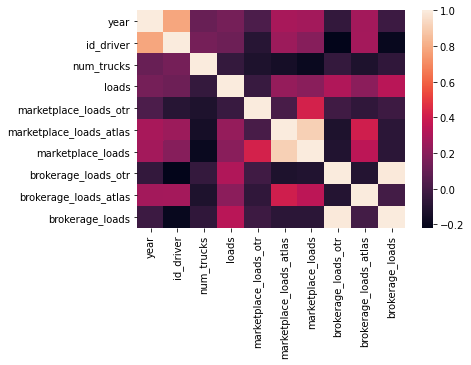

In [10]:
import seaborn as sns
ax = sns.heatmap(ds.corr())

## 4.Pipeline Implementation:

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin



ds_nolab = result.drop(columns= ["weekday","year","dim_carrier_type","dim_carrier_company_name"
                             ,"home_base_city", "home_base_state",
                             "carrier_trucks", "interested_in_drayage",
                             "port_qualified", "signup_source"], axis=1)


class AugmentFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_loads_per_num_trucks = True):
        self.add_loads_per_num_trucks = add_loads_per_num_trucks
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.add_loads_per_num_trucks:
            loads_per_num_trucks = X[:, 2] / X[:, 1]
            return np.c_[X, loads_per_num_trucks]
        else:
            return np.c_[X]


num_pipeline = Pipeline([('std_scaler', StandardScaler()),
                        ('attribs_adder', AugmentFeatures())])

numerical_features = list(ds_nolab)
categorical_features = ["dim_carrier_type","dim_carrier_company_name"
                        ,"home_base_city", "home_base_state"
                        ,"carrier_trucks", "interested_in_drayage"
                        ,"port_qualified", "signup_source"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ])

result_prepared = full_pipeline.fit_transform(result)

In [12]:
import scipy.sparse
new_test = result_prepared[83251:,:]
new_train = result_prepared[:83251,:]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(new_train, high_performance_arr, test_size=0.2, random_state=42)

## 5.Logistic Regression:

In [14]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(max_iter=500)
reg.fit(X_train, y_train)
y_prid = reg.predict(X_test)

In [15]:
from sklearn.metrics import r2_score
r2_score(y_test, y_prid)

0.9365311577088857

## 6.PCA (Principle Component Analysis):

In [16]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
'''
#PCA Didn't Work With Sparse Matrix, We Can Use TruncatedSVD
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)
'''
svd = TruncatedSVD(n_components=10).fit(X_train)
X_train_PCA = svd.transform(X_train)
X_test_PCA = svd.transform(X_test)

## 7. Ensemble Methods:

In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

BagCl = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 10), n_estimators=10)
BagCl.fit(X_train_PCA, y_train)
BagCl_Pred = BagCl.predict(X_test_PCA)

print('Bagging Accuracy:', metrics.accuracy_score(y_test, BagCl_Pred))
print('Bagging F1 Score:', metrics.f1_score(y_test, BagCl_Pred))
print("--------------")

AdaCl = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 10), n_estimators=10, learning_rate = 0.01)
AdaCl.fit(X_train_PCA, y_train)
AdaCl_Pred = AdaCl.predict(X_test_PCA)

print('Ada Accuracy:', metrics.accuracy_score(y_test, AdaCl_Pred))
print('Ada F1 Score:', metrics.f1_score(y_test, AdaCl_Pred))

Bagging Accuracy: 0.9987988709386824
Bagging F1 Score: 0.9951573849878935
--------------
Ada Accuracy: 0.9990390967509459
Ada F1 Score: 0.9961259079903148


## 8. Neural Net Classifier:

In [20]:
from sklearn.neural_network import MLPClassifier
NnCl = MLPClassifier(random_state=1, max_iter=200, hidden_layer_sizes=(30,30)).fit(X_train_PCA, y_train)
NnCl_Pred = NnCl.predict(X_test_PCA)

print('NN Accuracy:', metrics.accuracy_score(y_test, NnCl_Pred))
print('NN F1 Score:', metrics.f1_score(y_test, NnCl_Pred))

NN Accuracy: 0.999459491922407
NN F1 Score: 0.997822405032664


## 9. K-Fold Cross-validation:

In [281]:
from sklearn.model_selection import KFold
from numpy import mean

Data_PCA = svd.transform(new_train)

BagKf = KFold(n_splits=10)
Kfold_BagCl = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 10), n_estimators=10)
NnKf = KFold(n_splits=10)
Kfold_NnCl = MLPClassifier(random_state=1, max_iter=200, hidden_layer_sizes=(30,30))

score_BagCl = cross_val_score(Kfold_BagCl, Data_PCA, high_performance_arr, scoring='accuracy', cv=BagKf)
score_NnCl  = cross_val_score(Kfold_NnCl, Data_PCA, high_performance_arr, scoring='accuracy', cv=NnKf)
print('Bag_Kfolds_Accuracy:' , (mean(score_BagCl)))
print('NN_Kfolds_ Accuracy:' , (mean(score_NnCl)))

Bag_Kfolds_Accuracy: 0.9996997069132549
NN_Kfolds_ Accuracy: 0.9997357386211577


## 10.Custom Models:

#### Polynomial Regression:

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly_regr = linear_model.LinearRegression()
poly = PolynomialFeatures(degree = 5)
train_x_poly = poly.fit_transform(X_train)

poly_regr.fit(train_x_poly , y_train)
test_x_poly = poly.fit_transform(X_test)

poly_y_pred = poly_regr.predict(test_x_poly)

#### SVM (Support Vector Machine) with Kernels:

In [29]:
svm = SVC(kernel = "rbf").fit(X_train_PCA, y_train)
SVM_pred = svm.predict(X_test_PCA)

In [30]:
print(metrics.accuracy_score(y_test, SVM_pred))

0.9433667647588734


In [25]:
svm_poly = SVC(kernel = "poly").fit(X_train_PCA, y_train)
SVM_poly_pred = svm_poly.predict(X_test_PCA)

In [26]:
print(metrics.accuracy_score(y_test, SVM_poly_pred))

0.9130983124136689


In [27]:
svm_sig = SVC(kernel = "sigmoid").fit(X_train_PCA, y_train)
SVM_poly_pred = svm_sig.predict(X_test_PCA)

In [28]:
print(metrics.accuracy_score(y_test, SVM_poly_pred))

0.8658939403038857


#### Regression Based on K-Nearest Neighbors:

In [39]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train_PCA, y_train)
knn_pred = neigh.predict(X_test_PCA)

In [40]:
print(metrics.accuracy_score(y_test, knn_pred.round()))

0.9984385322202871


In [44]:
svd = TruncatedSVD(n_components=10).fit(new_test)
X_final_test_PCA = svd.transform(new_test)

## Fianl Predctions For score.csv

In [45]:
finalSVM = svm.predict(X_final_test_PCA)

In [48]:
finalKNN = neigh.predict(X_final_test_PCA)
finalKNN = finalKNN.round()

In [53]:
finalNn = NnCl.predict(X_final_test_PCA)

In [55]:
finalAda = AdaCl.predict(X_final_test_PCA)

In [62]:
finalcsv = pd.DataFrame(finalAda)

In [64]:
finalcsv.to_csv('out.csv')